In [3]:
import numpy as np
import pulser
from pulser.devices import DigitalAnalogDevice
from pulser.register import Register
from pulser.pulse import Pulse
from pulser.waveforms import BlackmanWaveform

# Qubovert

In [67]:
from qubovert.problems import GraphPartitioning
from qubovert.utils import solve_qubo_bruteforce as qubo_solver

In [68]:
# edges = {("a", "b"), ("a", "c"), ("c", "d"),
edges = {("a", "b"), ("c", "d")}

In [69]:
problem = GraphPartitioning(edges) 

In [70]:
problem.degree

1

In [71]:
Q = problem.to_qubo()

In [72]:
Q.pretty_str()

'2.0 x(0) x(1) - 2.0 x(0) - 2.0 x(1) + 4.0 + 2.0 x(0) x(2) - 2.0 x(2) + 2.0 x(1) x(3) - 2.0 x(3) + 2.0 x(2) x(3)'

In [73]:
problem.to_quso().pretty_str()

'0.5 z(0) z(1) + 0.5 z(0) z(2) + 0.5 z(1) z(3) + 2.0 + 0.5 z(2) z(3)'

In [74]:
problem.to_qubo()

{(0, 1): 2.0,
 (0,): -2.0,
 (1,): -2.0,
 (): 4.0,
 (0, 2): 2.0,
 (2,): -2.0,
 (1, 3): 2.0,
 (3,): -2.0,
 (2, 3): 2.0}

In [75]:
problem.to_quso()

{(0, 1): 0.5, (0, 2): 0.5, (1, 3): 0.5, (): 2.0, (2, 3): 0.5}

In [ ]:
obj, sol = qubo_solver(Q)

In [ ]:
sol # 0: a, 3: b, 1: c, 2: d

{0: 0, 1: 1, 2: 1, 3: 0}

In [44]:
solution = problem.convert_solution(sol)
solution

({'a', 'b'}, {'c', 'd'})

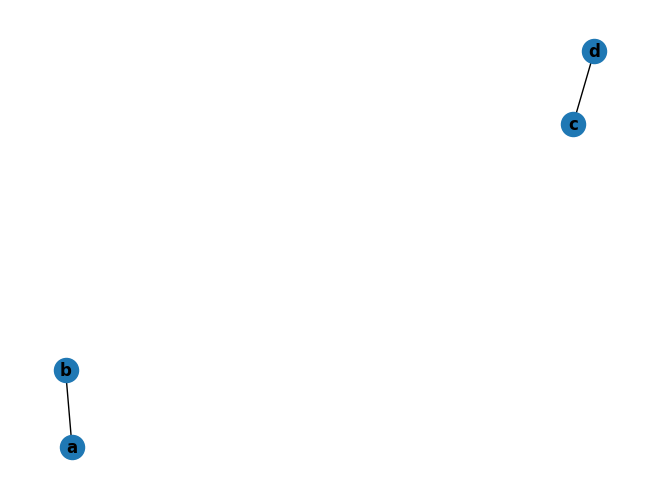

In [45]:
# draw the graph
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold')
plt.show()

# Solve with Pulser

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.devices import DigitalAnalogDevice
from pulser.waveforms import InterpolatedWaveform
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform

In [135]:
problem.to_qubo().pretty_str()

'2.0 x(0) x(1) - 2.0 x(0) - 2.0 x(1) + 4.0 + 2.0 x(0) x(2) - 2.0 x(2) + 2.0 x(1) x(3) - 2.0 x(3) + 2.0 x(2) x(3)'

In [1529]:
# Q_matrix = np.zeros((4, 4))
# Q = np.array([
#     [-2, 0, 2, 2],
#     [0, -2, 2, 2],
#     [2, 2, -2, 0],
#     [2, 2, 0, -2]
# ]) * 5

Q = np.array([
    [-2, 0, 1, 1],
    [0, -2, 1, 1],
    [1, 1, -2, 0],
    [1, 1, 0, -2]
])

In [1530]:
bitstrings = [np.binary_repr(i, len(Q)) for i in range(2 ** len(Q))]
costs = []
# this takes exponential time with the dimension of the QUBO
for b in bitstrings:
    z = np.array(list(b), dtype=int)
    cost = z.T @ Q @ z
    costs.append(cost)
zipped = zip(bitstrings, costs)
sort_zipped = sorted(zipped, key=lambda x: x[1])
print(sort_zipped[:3])

[('0011', -4), ('1100', -4), ('0001', -2)]


In [1387]:
def evaluate_mapping(new_coords, Q):
    """Cost function to minimize. Ideally, the pairwise distances are conserved."""
    new_coords = np.reshape(new_coords, (len(Q), 2))
    # computing the matrix of the distances between all coordinate pairs
    new_Q = squareform(
        DigitalAnalogDevice.interaction_coeff / pdist(new_coords) ** 6
    )
    return np.linalg.norm(new_Q - Q)

In [1419]:
costs = []
np.random.seed(2)
x0 = np.random.random(len(Q) * 2)
res = minimize(
    evaluate_mapping,
    x0,
    args=(Q,),
    method="Nelder-Mead",
    # method="CG",
    # method="COBYQA",
    # method = "L-BFGS-B",
    # method = "Powell",
    # method = "trust-constr",
    tol=1e-6,
    options={"maxiter": 20000000, "maxfev": None},
    bounds = [(-40, 40) for _ in range(len(Q) * 2)]
)
coords = np.reshape(res.x, (len(Q), 2))

In [1421]:
Q_new = squareform(
    DigitalAnalogDevice.interaction_coeff / pdist(coords) ** 6
)
Q_new

array([[0.        , 0.12403101, 0.99224806, 0.99224809],
       [0.12403101, 0.        , 0.9922481 , 0.99224803],
       [0.99224806, 0.9922481 , 0.        , 0.12403101],
       [0.99224809, 0.99224803, 0.12403101, 0.        ]])

In [1327]:
# make sure the coordinates are within the bounds of the device
coords = coords / np.max(np.abs(coords)) * 40

# make sure the minimum distance between the qubits is at least 4, but without going over the bounds of the device
min_dist = 4
for i in range(len(coords)):
    for j in range(i + 1, len(coords)):
        dist = np.linalg.norm(coords[i] - coords[j])
        if dist < min_dist:
            coords[j] = coords[j] + (min_dist - dist) * (coords[j] - coords[i]) / dist

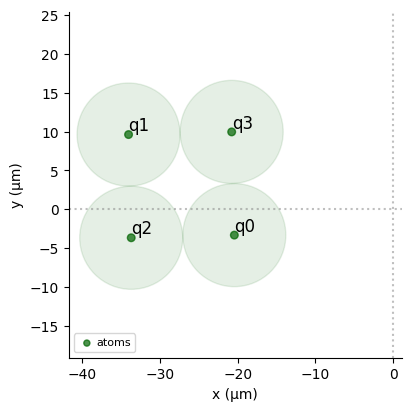

In [1422]:
qubits = {f"q{i}": coord for (i, coord) in enumerate(coords)}
reg = Register(qubits)
reg.draw(
    blockade_radius=DigitalAnalogDevice.rydberg_blockade_radius(1.0),
    draw_graph=False,
    draw_half_radius=True,
)

In [ ]:
Q_new

array([[0.        , 0.12403101, 0.99224806, 0.99224809],
       [0.12403101, 0.        , 0.9922481 , 0.99224803],
       [0.99224806, 0.9922481 , 0.        , 0.12403101],
       [0.99224809, 0.99224803, 0.12403101, 0.        ]])

In [1574]:
# We choose a median value between the min and the max
# Omega = np.median(Q[Q > 0].flatten())
# Omega = np.median(Q[Q > 1e-3].flatten())
Omega = 2.
delta_0 = -2.  # just has to be negative
delta_f = -delta_0  # just has to be positive
T = 10_000  # time in ns, we choose a time long enough to ensure the propagation of information in the system

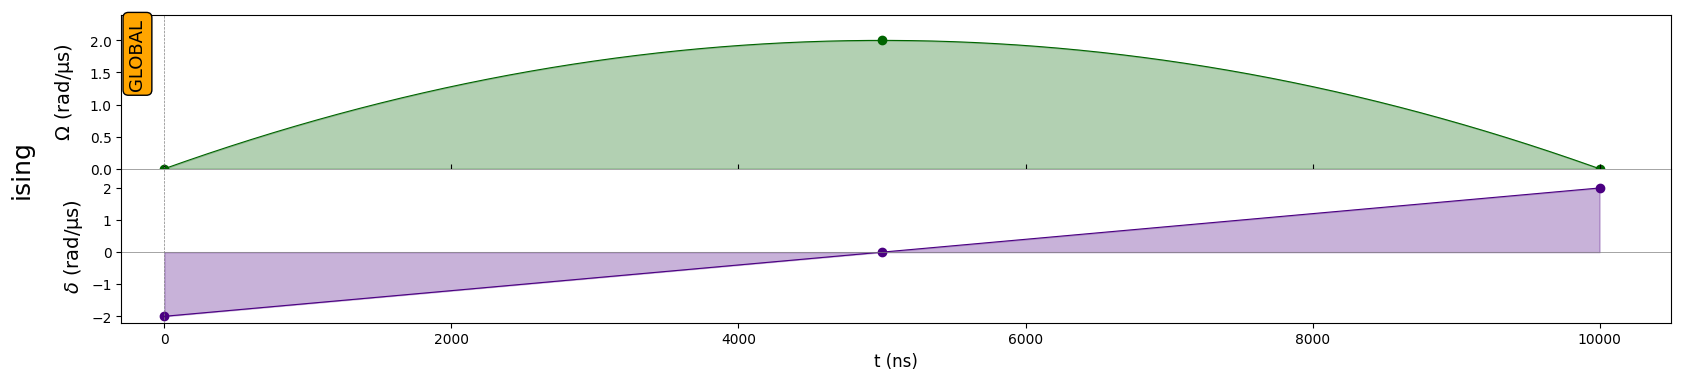

In [1575]:
adiabatic_pulse = Pulse(
    InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
    InterpolatedWaveform(T, [delta_0, 0, delta_f]),
    0,
)
seq = Sequence(reg, DigitalAnalogDevice)
seq.declare_channel("ising", "rydberg_global")
seq.add(adiabatic_pulse, "ising")
seq.draw()

In [1576]:
simul = QutipEmulator.from_sequence(seq)
results = simul.run()
final = results.get_final_state()
count_dict = results.sample_final_state()

In [1577]:
def plot_distribution(C):
    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))
    indices = ["0011", "1100"]  # QUBO solutions
    color_dict = {key: "r" if key in indices else "g" for key in C}
    plt.figure(figsize=(12, 6))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.bar(C.keys(), C.values(), width=0.5, color=color_dict.values())
    plt.xticks(rotation="vertical")
    plt.show()

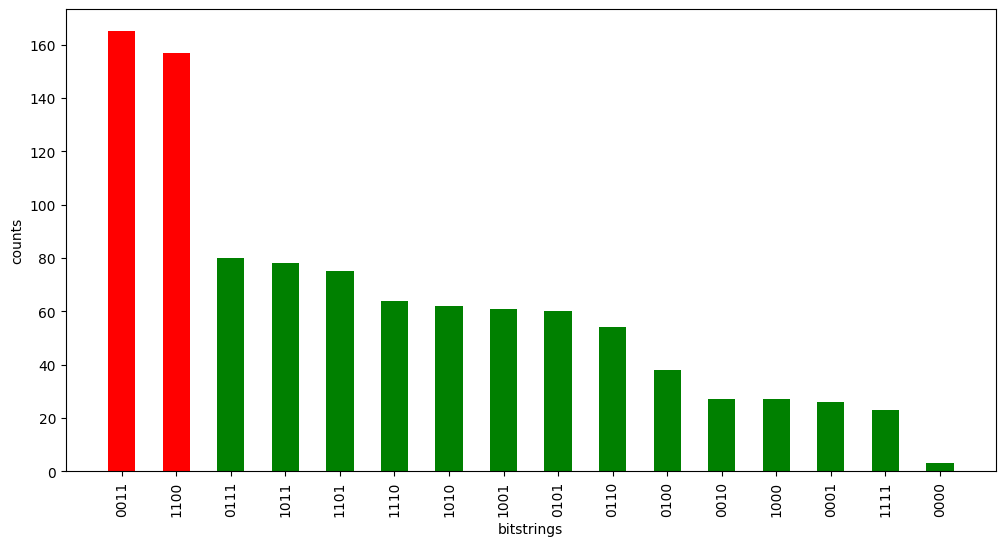

In [1578]:
plot_distribution(count_dict)

In [1536]:
def get_cost_colouring(bitstring, Q):
    z = np.array(list(bitstring), dtype=int)
    cost = z.T @ Q @ z
    return cost

def get_cost(counter, Q):
    cost = sum(counter[key] * get_cost_colouring(key, Q) for key in counter)
    return cost / sum(counter.values())  # Divide by total samples

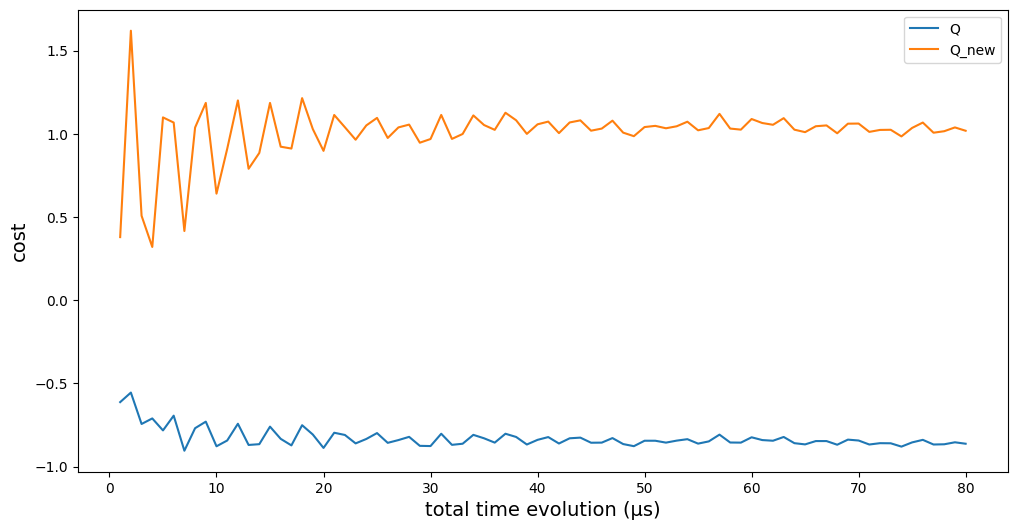

In [1590]:
cost_Q = []
cost_newQ = []
nn = 1 # takes very long, can also set to 1
t_end = 80
correct_counts = []
for T in 1000 * np.linspace(1, t_end, t_end*nn):
    seq = Sequence(reg, DigitalAnalogDevice)
    seq.declare_channel("ising", "rydberg_global")
    adiabatic_pulse = Pulse(
        InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
        InterpolatedWaveform(T, [delta_0, 0, delta_f]),
        0,
    )
    seq.add(adiabatic_pulse, "ising")
    simul = QutipEmulator.from_sequence(seq)
    results = simul.run()
    final = results.get_final_state()
    count_dict = results.sample_final_state()
    cost_newQ.append(get_cost(count_dict, Q_new) / 3)
    cost_Q.append(get_cost(count_dict, Q) / 3)
    correct_counts.append([count_dict.get("0011", 0) / sum(count_dict.values()), count_dict.get("1100", 0) / sum(count_dict.values())])

correct_counts = np.array(correct_counts)

plt.figure(figsize=(12, 6))
plt.plot(range(1, len(cost_Q)+1), np.array(cost_Q), label="Q")
plt.plot(range(1, len(cost_newQ)+1), np.array(cost_newQ), label="Q_new")
plt.xlabel("total time evolution (µs)", fontsize=14)
plt.ylabel("cost", fontsize=14)
plt.legend()
plt.show()

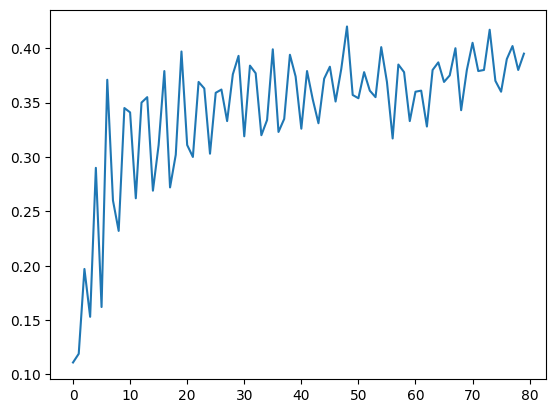

In [1592]:
plt.plot(correct_counts[:, 0] + correct_counts[:, 1])